In [ ]:
#데이터셋 다운로드 및 압축 해제
  #현재 google com 내 워킹 디렉토리 위치 파악(이건 무조건 해야 됨!)
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

import requests
import tarfile

# 데이터셋 다운로드 URL
data_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"

# 다운로드할 경로 설정
download_dir = "/content"

# 다운로드 받을 디렉토리 생성
if not os.path.exists(download_dir):
    os.makedirs(download_dir)#download_dir 경로에 디렉터리 만들기

# 데이터셋 다운로드
download_path = os.path.join(download_dir, "VOCtrainval_06-Nov-2007.tar")
response = requests.get(data_url, stream=True)
with open(download_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

# 압축 해제
with tarfile.open(download_path, "r") as tar:
    tar.extractall(download_dir)

# 압축 파일 삭제
os.remove(download_path)

print("PASCAL VOC 2007 데이터셋 다운로드 및 압축 해제 완료.")

Current Working Directory: /content
PASCAL VOC 2007 데이터셋 다운로드 및 압축 해제 완료.


In [ ]:
#데이터 셋으로부터 이미지, 라벨들만 뽑아내고, 이미지 파일을 numpy 배열(n_H*n_W*n_ch) 형태로 바꾸기

#전처리 시작
import os
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import Counter

class image_label_extract():
  def __init__(self,sample_num):# sample_num은 내가 데이터셋에서 쓸 sample 수 - 전체 sample을 이용할 거면, 0
  # 데이터셋 디렉토리 설정
    dataset_dir = "/content/VOCdevkit/VOC2007"
    jpeg_images_dir = os.path.join(dataset_dir, "JPEGImages")#JPEGimage들이 있는 디렉터리 주소
    annotations_dir = os.path.join(dataset_dir, "Annotations")#각 image에 대응되는 주석들이 저장됨.

  # JPEGImages 디렉토리 내의 이미지 파일 목록 가져오기
    image_files = [f for f in os.listdir(jpeg_images_dir) if f.endswith('.jpg')]

  #모든 image 샘플들을 하나의 집합으로(이후 4차원 Tensor로 만들 것) - 이 images list에는 numpy 배열 type의 image를 저장하게 할 것
    self.images=list([])
    self.rare_images=list([])
  #각 image에 대응되는 label들의 쌍을 하나의 집합(multi_labels)으로
    self.multi_labels=list([])
    if sample_num==0:#0이면 전체 샘플을 사용할 것이라는 의미
      for image_file in image_files:
        image_path = os.path.join(jpeg_images_dir, image_file)#각 image들의 주소(위치)
        labels=list([])#각 image에 들어있는 모든 object name들이 들어갈 것

      # 이미지 출력
        image = Image.open(image_path)#해당 주소의 image 객체 생성

      # 해당 이미지에 대응하는 주석 파일 불러오기
        annotation_file = os.path.splitext(image_file)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_file)

      # 주석 파일 파싱
        tree = ET.parse(annotation_path)
        root = tree.getroot()

      # 객체 정보 출력(이미지 내 존재하는 객체들의 이름 출력)
        for obj in root.findall('object'):#각 image에 대응되는 주석 파일에 있는 object들을 하나씩 불러오는 것.(즉, image에 있는 object를 ....)
          name = obj.find('name').text
          labels.append(name)
        image_array = np.array(image)
        self.images.append(image_array)
        self.rare_images.append(image)#전처리 안 한 img도 따로 저장할 것
        self.multi_labels.append(labels)#각각의 labels들이 묶음이 되도록 만들기
    else:
      for image_file in image_files[:sample_num]:
        image_path = os.path.join(jpeg_images_dir, image_file)#각 image들의 주소(위치)
        labels=list([])#각 image에 들어있는 모든 object name들이 들어갈 것

      # 이미지 출력
        image = Image.open(image_path)#해당 주소의 image 객체 생성

      # 해당 이미지에 대응하는 주석 파일 불러오기
        annotation_file = os.path.splitext(image_file)[0] + '.xml'
        annotation_path = os.path.join(annotations_dir, annotation_file)

      # 주석 파일 파싱
        tree = ET.parse(annotation_path)
        root = tree.getroot()

      # 객체 정보 출력(이미지 내 존재하는 객체들의 이름 출력)
        for obj in root.findall('object'):
          name = obj.find('name').text
          labels.append(name)
        image_array = np.array(image)#image를 numpy로 맞춰야됨!
        
        self.images.append(image_array)
        self.rare_images.append(image)
        self.multi_labels.append(labels)#각각의 labels들이 묶음이 되도록 만들기


    print("multi_labels 개수 : ", len(self.multi_labels))

    #단어들을 전체 문장들에서 나타난 빈도수에 맞춰 각 리스트 원소 정렬시키기!
    print("정렬 전 multi_labels : ",self.multi_labels)
    word_counts = Counter(word for sentence in self.multi_labels for word in sentence)
    print(type(word_counts))
    for sentence in self.multi_labels:
      sentence.append("end")

    print("중복 단어 제거 전, sentence들 : ", self.multi_labels)
    for i in range(len(self.multi_labels)):
      unique_words = []
      for word in self.multi_labels[i]:
        if word not in unique_words:
          unique_words.append(word)
      self.multi_labels[i]=unique_words

    print("images 개수 : ", len(self.images))

#main에 쓸 부분
image_label=image_label_extract(0)#전체 샘플 뽑고 싶으면, 0 입력
image_list = image_label.images
multi_labels = image_label.multi_labels
print("multi_labels 개수 : ", len(multi_labels))
print(image_label.multi_labels)
print("images 개수 : ", len(image_list))
print("images type : ", type(image_list))#list임
print("multi_labels = ",multi_labels)
print("multi_labels type : ", type(multi_labels))

multi_labels 개수 :  5011
정렬 전 multi_labels :  [['boat', 'person', 'person'], ['chair', 'person'], ['bicycle', 'person', 'person', 'chair', 'bicycle'], ['bottle'], ['person', 'person', 'sofa'], ['motorbike', 'person'], ['bicycle'], ['person', 'bicycle'], ['person', 'person', 'sofa', 'pottedplant', 'bottle', 'bottle'], ['person', 'horse'], ['boat'], ['aeroplane', 'aeroplane', 'aeroplane', 'aeroplane', 'aeroplane'], ['motorbike', 'person', 'person'], ['bottle', 'person', 'person'], ['person', 'pottedplant'], ['tvmonitor'], ['tvmonitor', 'person'], ['sofa', 'person'], ['horse'], ['bus', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person'], ['bicycle', 'bicycle', 'bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person', 'person', 'person', 'car', 'car', 'car'], ['bus'], ['dog'], ['cat'], ['dog'], ['person', 'dog'], ['car'], ['person', 'person', 'person', 'person', 'motorbike'], ['bird'], ['boat'], ['diningtable', 'pottedplant', 'person', 'person', 'person'], [

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams#skipgrams 함수는 Skip-gram 모델을 학습하기 위해 필요한 학습 데이터를 생성하는 역할 -> 즉, SGNS 데이터셋을 만드는 과정 참고해보면,
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, LSTM, Layer, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences#문장 패딩해주는 애
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

class word_processing_layer():
  def __init__(self,sentences,images,embedding_dimension):
    self.multi_labels = sentences
    self.images=images
      #2-1-1 : sentences의 원소들 중, None or []이 있는 index 뽑기 그 후, 해당 index 제거! 이에 대응되는 image도 전부 지워줘야 됨!
    indices_of_none_or_x = [index for index, item in enumerate(self.multi_labels) if item is None or item==[]]
    self.multi_labels = [self.multi_labels[index] for index in range(len(self.multi_labels)) if index not in indices_of_none_or_x]
    self.images = [self.images[index] for index in range(len(self.images)) if index not in indices_of_none_or_x]환

      #2-1-2 : multi_labels에서 object 1개짜리만 있는 img들의 index 확인 및 multi_labels, images의 image 제거(중심-주변 단어 embedding(SGNS) 할 때, 이들은 의미가 없기에)
    indices_of_1 = [index for index, item in enumerate(self.multi_labels) if len(item)==1]
    self.multi_labels = [self.multi_labels[index] for index in range(len(self.multi_labels)) if index not in indices_of_1]
    self.images = [self.images[index] for index in range(len(self.images)) if index not in indices_of_1]
    self.images = np.array(self.images)

      #2-2 : 정수 인코딩
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(self.multi_labels)
    self.vocab = tokenizer.word_index#단어 집합(어휘사전)


      #문장(multi_labels)들을 정수 인코딩된 형태로 나타내어 저장하기 / tokenizer로 문장 정수 인코딩할 땐, self.multi_labels처럼, 리스트[] 안에, 각 문장들이 토큰화되어 []로 저장되어 있어야 한다!
    self.encoded_multi_labels=tokenizer.texts_to_sequences(self.multi_labels)#토큰화된 sample 문장들의 각 토큰을 정수로 -> 나중에 패딩 후, 각 정수는 embedding vector들로 표현되어 input 데이터가 될 것!
    #tokennizer로부터 encoding된 multi_label 구하면, 이는 list!
    print('문장의 최대 길이 :',max(len(sentence) for sentence in self.encoded_multi_labels))
    print('리뷰의 평균 길이 :',sum(map(len, self.encoded_multi_labels))/len(self.encoded_multi_labels))
    plt.hist([len(sentence) for sentence in self.encoded_multi_labels], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()#보면, 문장 최대 4 이상은 거의 없기에, 이후 패딩시, 패딩 길이 4으로 하기!



    self.vocab_size = len(self.vocab) + 1  
    print('단어 집합의 크기 :', self.vocab_size)
    self.idx2vocab = {value : key for key, value in self.vocab.items()}
    self.idx2vocab[0] = "<pad>"
    print("idx2vocab = ",self.idx2vocab)


    #2-3 SGNS
       #2-3-1 : SGNS 모델 구성
    input_center = Input(shape=(1,), dtype=tf.int32)
    input_context = Input(shape=(1,), dtype=tf.int32)
    embedding_layer = Embedding(input_dim=self.vocab_size, output_dim=embedding_dimension)
    center_embedding = embedding_layer(input_center)
    context_embedding = embedding_layer(input_context)#주변 단어 ...
    dot_product = Dot(axes=2)([center_embedding, context_embedding])#두 emb vector의 내적
    output = Dense(1, activation='sigmoid')(dot_product)#이 것에 sigmoid만 씌운 것
    model = tf.keras.Model(inputs=[input_center, input_context], outputs=output)

        # 손실 함수 정의 및 모델 컴파일
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        #SGNS 모델 학습
    for epoch in range(1, 6):
        #2-3-1 네거티브 샘플링
        self.skip_grams = [skipgrams(sample, vocabulary_size=self.vocab_size, window_size=2) for sample in self.encoded_multi_labels]
        loss = 0
        for _, elem in enumerate(self.skip_grams):
            first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
            second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
            labels = np.array(elem[1], dtype='int32')
            X = [first_elem.reshape(-1,1), second_elem.reshape(-1,1)]
            Y = labels.reshape(-1,1)
            loss += model.train_on_batch(X,Y)[0]
            accuracy=  model.train_on_batch(X,Y)[1]
        print('Epoch :',epoch, 'Loss :',loss, 'accuracy : ',accuracy)

    # 단어 임베딩 추출
    self.word_embeddings_table = embedding_layer.get_weights()[0]
    print("embedding tabel shape : ",self.word_embeddings_table.shape)
    print("type(self.word_embeddings_table) : ",type(self.word_embeddings_table))

    # 2-4 패딩
    print("self.multi_labels(토큰화된 정수 인코딩 전 문장들의 list) = ",self.multi_labels)
    print("self.encoded_multi_labels type = ",type(self.encoded_multi_labels)) 
    print("self.encoded_multi_labels(토큰화된 정수 인코딩 후 문장들의 list) = ",self.encoded_multi_labels)

    self.encoded_multi_labels_padded_for_answer = pad_sequences(self.encoded_multi_labels, maxlen=4,padding='post')
    print("self.encoded_multi_labels_padded_for_answer : \n",self.encoded_multi_labels_padded_for_answer)#이건 정답 label이기에, embedding은 필요 x -> 그냥 정답 label로서 train할 때만 필요!
    print("self.encoded_multi_labels_padded_for_answer shape =",self.encoded_multi_labels_padded_for_answer.shape)

    #패딩했을 때, 0으로 끝나지 않는 sample들의 index를 모두 찾아 이에 대응되는 images와 함께 제거
    non_zero_rows = np.where(self.encoded_multi_labels_padded_for_answer[:, -1] != 0)[0]#non_zero_rows는 이 padding된 sentence들에서 마지막 열이 0이 아닌 행들의 index를 모은 np.array.
    print("마지막 열이 0이 아닌 sentence(행)의 index 모음(array) : \n",non_zero_rows)
    print(type(non_zero_rows))#numpy 배열

    self.encoded_multi_labels_padded_for_answer = np.delete(self.encoded_multi_labels_padded_for_answer, non_zero_rows, axis=0)#마지막 열이 0이 아닌 행(axis=0)들을 모두 제거함.
    print("제거 후 남은 sentence 수와 image 수가 동일해야 서로 대응되는 index들이 제거되었음을 알 수 있다.")
    print("제거 후 남은 sentence 수",len(self.encoded_multi_labels_padded_for_answer))

    self.images = [self.images[i] for i in range(len(self.images)) if i not in non_zero_rows]
    print("제거 후 남은 image 수",len(self.images))

    #문장 embedding
  def __call__(self):
    # 사전 훈련된 임베딩 행렬(self.word_embeddings)을 사용하여 Embedding 레이어 초기화
    pretrained_embedding_matrix = self.word_embeddings_table
    vocab_size = pretrained_embedding_matrix.shape[0]#행의 개수 = padding 토큰 포함 vocab 총 개수 (어휘사전 index = 행 index)
    embedding_dim = pretrained_embedding_matrix.shape[1]#각 단어들의 embedding vector 크기
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[pretrained_embedding_matrix],
        trainable=False)  # 임베딩 행렬을 고정
#    print("embedded_sentences=",embedded_sentences)
    pretrained_embedding_matrix=tf.constant(pretrained_embedding_matrix,dtype=tf.float32)
    print("type of pretrained_embedding_matrix : ",type(pretrained_embedding_matrix))
    return self.images, self.vocab, self.encoded_multi_labels, self.encoded_multi_labels_padded_for_answer , self.encoded_multi_labels_padded_for_answer.shape[1], self.idx2vocab, pretrained_embedding_matrix#self.encoded_multi_labels_padded는 모델의 정답




In [ ]:
#모델 훈련 및 평가

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Dense, LSTM, Layer, Activation, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences#문장 패딩해주는 애
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
class EncoderCNN(Model):#전이학습 한 번에 끝내기 위해 한 것
  def __init__(self,embedding_dimension):
    super().__init__()
    #출력층 빠진(Flatten 전) vgg_model 객체 만들기
    self.vgg=VGG16(weights="imagenet",include_top=False)
    #모든 layer는 trainable=True가 default이니, pretrained된 vgg는 그렇지 않게 설정하기 -> dense부분만 훈련될 수 잇게 하기

    for layer in self.vgg.layers:
      layer.trainable=False
    self.flatten = Flatten()
    self.dense1=Dense(units=512,activation="relu")
    self.dense2=Dense(units=256,activation="relu")
    self.dense3=Dense(units=embedding_dimension,activation="relu")
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.01)
    print("dense1.trainable = ",self.dense1.trainable)
    print("dense2.trainable = ",self.dense2.trainable)
    print("dense3.trainable = ",self.dense3.trainable)

  def __call__(self, image):
     #1. 이미지 전처리
    print("Image type(변환 전) : ",type(image))
    if not isinstance(image,tf.Tensor):
      image = tf.constant(image,dtype=tf.float32)
    if len(image.shape) != 4: 
      image = tf.expand_dims(image, axis=0)#개수(batch)에 대한 차원이 없으니, 차원 추가
    # 이미지 크기 조절
    if image.shape[1] != 224 or image.shape[2] != 224:
      image = tf.image.resize_with_crop_or_pad(image, 224, 224)#(sample수, 224,224,3)or(224,224,3)으로 되돌려 줄 것
    image = preprocess_input(image)#입력 이미지를 VGG16 모델 또는 다른 일부 모델에 맞게 사전 처리(평균 값 제거/채널 정규화)
    x=self.vgg(image)
    x=self.flatten(x)
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    x=self.bn(x)
    return x

class DecoderRNN(Model):
  def __init__(self, length_padded_sentence,embedding_dimension,hidden_size, vocab_size, embedding_table):
    super().__init__()

    self.length_padded_sentence = length_padded_sentence
    self.hidden_size=hidden_size
    self.embedding_table = embedding_table # embedding table은 word은 embedding vecctor로 바꾸는 matrix로, shape = (vocab_size,embedding_dimension)
    self.vocab_size=vocab_size
    self.lstm = LSTM(units=hidden_size, return_sequences=True, return_state=True) # units는 hidden state의 크기 의미
    #input_shape입력 안 하면, 3차원 텐서가 input값임!(sample수, 문장 길이, emb_size)
    self.prediction = Dense(units=vocab_size,activation="softmax")

  def __call__(self,images_features):# images_features shape = (sample 수,embedding_dimension)
    #각 이미지 feature 벡터마다 한 문장(문장 길이 : length_padded_sentence)을 예측하는데
    #방법은 하나의 image feature 벡터마다 단어 1개씩 예측하며 한 문장 만들기
    Y=tf.zeros([0,self.length_padded_sentence,self.vocab_size],dtype=tf.float32)#예측값의 shape = (sample수, 문장길이, vocab_size)가 될 것이다.
    for i in range(images_features.shape[0]):
      predicted_words=tf.zeros([0,self.vocab_size])#shape = (문장길이,vocab_size)
      feature = images_features[i]#차원 수가 (sample수,embedding_dimension) -> (sample수,)로 줄기에, 다시 크기 맞춰주기(for lstm input shape = (sample,문장길이,emb_size))
      feature = tf.expand_dims(tf.expand_dims(feature,axis=0),axis=0)
      embedded_word = feature
      last_hidden_state = tf.zeros((1,self.hidden_size))#보통 state 초기값은 0으로 시작
      last_cell_state = tf.zeros((1,self.hidden_size))
      initial_state = [last_hidden_state,last_cell_state]
      for j in range(self.length_padded_sentence):
        hidden_states,last_hidden_state, last_cell_state=self.lstm(embedded_word,initial_state=initial_state)
        print("hidden_states = \n",hidden_states)
        print("last_hidden_state = \n",last_hidden_state)
        print("last_cell_state = \n",last_cell_state)
        initial_state = [last_hidden_state,last_cell_state]#다음 word의 lstm에 intial state으로 들어갈 것.
        next_word_probability = self.prediction(last_hidden_state)
        predicted_words=tf.concat([predicted_words,next_word_probability],axis=0)
        next_word_probability = tf.squeeze(next_word_probability)#벡터로 바꿔줌 -> shape = (vocab_size,)
        next_word_idx = tf.argmax(next_word_probability)
        embedded_word = self.embedding_table[next_word_idx]
        embedded_word = tf.expand_dims(tf.expand_dims(embedded_word,axis=0),axis=0)
        #이 for loop가 다 돌 때마다, 하나의 문장에 대한 확률 2차원 텐서 predicted_words가 완성된다.
      predicted_words=tf.expand_dims(predicted_words,axis=0)
      Y=tf.concat([Y,predicted_words],axis=0)
    print("Y shape = ", Y.shape)
    return Y




In [ ]:
class CNN_RNN(Model):
  def __init__(self,sentences,images_numpy,embedding_dimension=16,hidden_size=64):#여기서 images_numpy는 행의 수 = 224, 열의 수 = 224로 전처리가 되어 있어야 한다!(for vgg)-2번째 셀
    super().__init__()

    self.word_processing_layer=word_processing_layer(sentences,images_numpy,embedding_dimension=embedding_dimension)
    self.image_list, self.vocab, self.encoded_multi_labels, self.encoded_multi_labels_padded_for_answer , self.len_padded_sentence,self.idx2vocab,self.pretrained_embedding_matrix = self.word_processing_layer()

    self.images = tf.zeros([0,224,224,3],dtype=tf.float32)
    for image in self.image_list:
      image = tf.image.resize_with_crop_or_pad(image, 224, 224)
      image = tf.cast(image, tf.float32)
      image = tf.expand_dims(image,axis=0)
      self.images = tf.concat([self.images,image],axis=0)
    print("images shape = ",self.images.shape)

    self.Encoder = EncoderCNN(embedding_dimension)#원래 분류할 땐, cnn에 클래스 수가 들어가지만, 여기선 이미지가 첫 단어를 뽑아내는 것으로 해석해서 emb size!
    self.Decoder = DecoderRNN(length_padded_sentence=self.len_padded_sentence,embedding_dimension=embedding_dimension,hidden_size=hidden_size,vocab_size=len(self.idx2vocab),embedding_table=self.pretrained_embedding_matrix)

  def __call__(self,images,training=False):
    features=self.Encoder(images)#features = (sample 수, class 수)
    print("features shape : ",features.shape)
    Y=self.Decoder(features)
    #decoding layer에서 정수 인코딩 필요(beam search decoder에서만)
    return Y


<ipython-input-3-67f58bdf6c53>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.images = np.array(self.images)


문장의 최대 길이 : 8
리뷰의 평균 길이 : 2.579125922969467


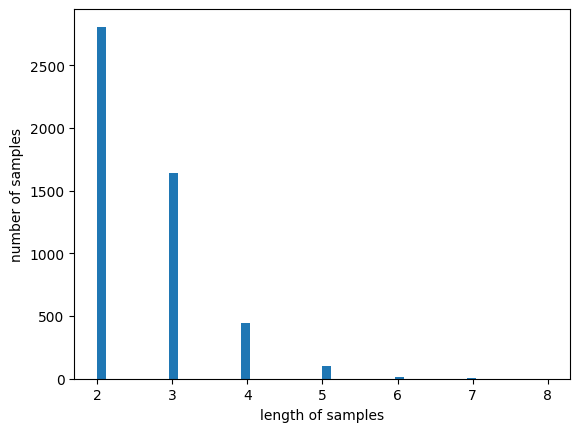

단어 집합의 크기 : 22
idx2vocab =  {1: 'end', 2: 'person', 3: 'car', 4: 'chair', 5: 'dog', 6: 'sofa', 7: 'cat', 8: 'bird', 9: 'horse', 10: 'tvmonitor', 11: 'pottedplant', 12: 'diningtable', 13: 'train', 14: 'bottle', 15: 'bicycle', 16: 'motorbike', 17: 'aeroplane', 18: 'bus', 19: 'boat', 20: 'cow', 21: 'sheep', 0: '<pad>'}
Epoch : 1 Loss : 3147.7149923741817 accuracy :  0.5
Epoch : 2 Loss : 3003.206234201789 accuracy :  0.25
Epoch : 3 Loss : 2953.0374157726765 accuracy :  0.5
Epoch : 4 Loss : 2963.835533514619 accuracy :  0.25
Epoch : 5 Loss : 2934.465616956353 accuracy :  0.5
embedding tabel shape :  (22, 16)
type(self.word_embeddings_table) :  <class 'numpy.ndarray'>
self.multi_labels(토큰화된 정수 인코딩 전 문장들의 list) =  [['boat', 'person', 'end'], ['chair', 'person', 'end'], ['bicycle', 'person', 'chair', 'end'], ['bottle', 'end'], ['person', 'sofa', 'end'], ['motorbike', 'person', 'end'], ['bicycle', 'end'], ['person', 'bicycle', 'end'], ['person', 'sofa', 'pottedplant', 'bottle', 'end'], ['person

In [ ]:
#main에 이어서 들어갈 부분
cnn_rnn = CNN_RNN(multi_labels,image_list,embedding_dimension=16,hidden_size=64)
print("image 수 : ",len(cnn_rnn.images))
print("문장 수 : ",len(cnn_rnn.encoded_multi_labels_padded_for_answer))
print("문장 길이 : ",cnn_rnn.len_padded_sentence)
#정답 라벨(self.encoded_multi_labels_paded)은 shape = (sample 수(batch_size),문장 길이)로, 이 때, shape[1]차원에 들어가는 애들은 단어들이 정수 인코딩 된 상태!(sparse_categorical_cross entropy일 때)

In [ ]:
#모델 훈련 및 평가(1,2중 하나)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_list=[EarlyStopping(monitor="val_accuracy",patience=3),ModelCheckpoint(filepath="/content/checkpoint_path.keras",monitor="val_loss",save_best_only=True)]#callback 사용하기 위해 정의함.(model.fit에서)
#1.데이터 split해서 훈련 데이터, train data로 나눠서 해보기( tf.data.Dataset.from_tensor_slices는 오류남)
cnn_rnn.compile(optimizer='rmsprop',loss="SparseCategoricalCrossentropy",metrics=["SparseCategoricalAccuracy"])
  # 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((cnn_rnn.images, cnn_rnn.encoded_multi_labels_padded_for_answer))

num_epochs=5

for epoch in range(num_epochs):
  print("epoch = ",epoch+1)

  # 데이터셋 섞기
  dataset_p = dataset.shuffle(buffer_size=len(cnn_rnn.encoded_multi_labels_padded_for_answer))#에포크마다 dataset 다시 shuffle -> 새로운 훈련데이터셋, 테스트 데이터셋 만들기

  # 훈련 세트와 테스트 세트로 나누기 + 평가
  train_size = int(0.8 * len(cnn_rnn.encoded_multi_labels_padded_for_answer))  # 전체 데이터 중 80%를 훈련 세트로
  test_size = len(cnn_rnn.encoded_multi_labels_padded_for_answer) - train_size  # 나머지 20%를 테스트 세트로
  train_dataset = dataset_p.take(train_size)
  test_dataset = dataset_p.skip(train_size)
  cnn_rnn.fit(train_dataset,batch_size=64,callbacks=callbacks_list)
  test_loss, test_accuracy = cnn_rnn.evaluate(test_dataset,batch_size=64)
  print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


epoch =  1
Image type(변환 전) :  <class 'tensorflow.python.framework.ops.Tensor'>
features shape :  (1, 16)
hidden_states = 
 Tensor("lstm_3/PartitionedCall:1", shape=(1, 1, 64), dtype=float32)
last_hidden_state = 
 Tensor("lstm_3/PartitionedCall:2", shape=(1, 64), dtype=float32)
last_cell_state = 
 Tensor("lstm_3/PartitionedCall:3", shape=(1, 64), dtype=float32)
hidden_states = 
 Tensor("lstm_3/PartitionedCall_1:1", shape=(1, 1, 64), dtype=float32)
last_hidden_state = 
 Tensor("lstm_3/PartitionedCall_1:2", shape=(1, 64), dtype=float32)
last_cell_state = 
 Tensor("lstm_3/PartitionedCall_1:3", shape=(1, 64), dtype=float32)
hidden_states = 
 Tensor("lstm_3/PartitionedCall_2:1", shape=(1, 1, 64), dtype=float32)
last_hidden_state = 
 Tensor("lstm_3/PartitionedCall_2:2", shape=(1, 64), dtype=float32)
last_cell_state = 
 Tensor("lstm_3/PartitionedCall_2:3", shape=(1, 64), dtype=float32)
hidden_states = 
 Tensor("lstm_3/PartitionedCall_3:1", shape=(1, 1, 64), dtype=float32)
last_hidden_state = 

In [ ]:
#모델 실 사용
import tensorflow as tf
class Node():#이렇게 내부 클래스 가능
  def __init__(self,word_index,probability,prev_node,next_nodes,num_layer,model):
     self.word_index=word_index
     if prev_node != None and prev_node !=[]:#prev_node !=[]는 tail의 prev_node만 list로 여러 개 오기 때문에, 처음 tail 생성시 필요
       print("head or tail 아님")
       if model.idx2vocab[word_index] != "end" and model.idx2vocab[word_index] != "<pad>" and num_layer>=2:
        print("end or pad 아님")
         #self.probability=prev_node.probability-tf.math.log(probability*self.length_penalty(num_layer))
        self.probability=prev_node.probability-tf.math.log(probability/0.8)#length penalty로 둘 중 하나 선택하기
       else:
        print("end or pad임")
        self.probability=prev_node.probability-tf.math.log(probability)#end 토큰이 나올 때까지 beam search에서 이 과정이 반복될 텐데, 그럼, end토큰이 있는 노드들의 probability중 가장 작은 값을 가진 토큰의 path가 가장 맞을 확률이 높은 path가 된다!
     else :
      print("head or tail임")
      self.probability=-tf.math.log(probability)#head, tail 때문에 이렇게 했음.
      print("head의 probability : {}, -tf.math.log(probability) : {},누적확률 : {}".format(probability,-tf.math.log(probability),self.probability))

     self.prev_node = prev_node
     self.next_nodes = next_nodes#이 노드 객체의 word로부터 딥러닝 모델을 거처 예상된 k개의 후보 단어들을 저장할 각각의 노드들로, list에 노드들이 각각 들어갈 것임
     self.num_layer = num_layer#이 노드가 몇 번째 layer에 있는지 의미(int임)
     if word_index != None:
      print("{}번째 층의 node의 word : {}, probability : {}, -tf.math.log(probability) : {},누적확률 : {}".format(num_layer,model.idx2vocab[word_index],probability,-tf.math.log(probability),self.probability))

class BeamSearchDecoder():#약간만 수정하면 다른 모델에도 응용할 수 있게 만들었음
  def __init__(self, beam_size, model):#여기서 모델은 train이 끝난 모델로, CNN_RNN 모델 객체가 들어갈 것!
    self.beam_size=beam_size
    self.idx2vocab=model.idx2vocab#인덱스에 단어 대응시키는 어휘사전 필요
    self.Encoder = model.Encoder#image를 넣어 start 단어 만들 것
  # print("self.CNN까진 오류 없음")
    self.lstm = model.Decoder.lstm
    self.prediction_layer = model.Decoder.prediction
    self.pretrained_embedding_matrix=model.pretrained_embedding_matrix
    self.len_padded_sentence = model.len_padded_sentence
    self.model = model
    self.num = 0#문장 길이만큼 prediction 반복시 그만하게 하게 할 것
  #  print("self.num까진 오류 없음")
    self.head = Node(None,1.0,None, None,0,model) ; self.tail = Node(None,1.0,list([]),None,self.len_padded_sentence,model)
  #  print("head, tail 정의까진 ...")
    self.head.next_nodes = self.tail#head의 word index에는 CNN을 거쳐 예측한 첫 단어의 index가 들어가고, 이에 맞는 probability가 들어갈 것
  def __call__(self, Image):#전처리 안 된 것이어도 상관 없음. CNN에서 하게 했음.
    #head 노드에 정보 완벽히 넣기(즉, start word 뽑기 ) -> 이후, 이로부터 beam_search 시작
    start_word_feature = self.Encoder(Image)#shape = (sample수, emb_size)인데, lstm의 input형태 맞추기 위해 axis=1에 차언 추가하기
    start_word_feature = tf.expand_dims(start_word_feature,axis=1)
    hidden_states, last_hidden_state, last_cell_state = self.lstm(start_word_feature) 
    print("cnn 결과값 = \n",start_word_feature)
    print("cnn 결과값 shape = ",start_word_feature.shape)

    initial_state = [last_hidden_state,last_cell_state]
    Y = self.prediction_layer(hidden_states) # (sample수, 문장 내 단어 수, vocab_size) | 어차피 단어 1개만 넣었기에, shape만 1차원 차이나지, hidden_states= last_hidden_state

    #첫 단어(start_word_feature)로부터 beam_size 개의 예측 단어 뽑아서 for 문으로 여기서부터 prediction 시작
      #첫 단어로부터 예측되는 단어들의 확률(Y)의 index을 beam_size개 봅기(큰 거부터 차례대로)
    print("sort 전 Y shape = ",Y.shape)
    sorted_indices = tf.argsort(Y,axis=2,direction='DESCENDING')
    top_k_indices = sorted_indices[:,:,:self.beam_size]
    max_indexes = tf.squeeze(top_k_indices)
    max_indexes = max_indexes.numpy().tolist()
      #이 index로부터 각각의 확률 뽑기 -> 이들이 최대 확률
    probabilities = list([])
    Y=tf.squeeze(Y)
    for i in range(self.beam_size):
      probabilities.append(Y[max_indexes[i]])
    print("첫번째 예측 확률(node에 저장 전(즉, -log 씌우기 전)) : ",probabilities)
      #첫 단어로부터 예측 단어 beam_)size개 봅기
    next_words = self.insert(max_indexes,probabilities=probabilities,present_node = self.head)#insert 함수를 보면 알 수 있듯이, next_words는 노드 객체 리스트임!

    #beam_search시작
    for word in next_words:
      self.prediction(word,initial_state, start_word_feature,self.beam_size)#beam_search 시작 -> tail의 previous node(end 토큰)
    #path찾기
    sentence = self.search_max_prob_nodes(self.tail)

    return sentence

  def insert(self, word_indexes, probabilities, present_node):
    present_node.next_nodes = list([])#원래 가장 최근 노드는 tail을 가리키고 있지만, 이를 list로 만들고
    for i in range(self.beam_size):#word_indexes, probabilities 모두 beam_size일 테니,
      present_node.next_nodes.append(Node(word_indexes[i],probabilities[i],present_node,self.tail,present_node.num_layer+1,self.model))#present_node, self.tail을 가리키는 노드 만들기
    for i in range(self.beam_size):#그리고 이렇게 생성된 새로운 노드들(present_node.next_nodes) 중, end 토큰을 저장한 애들은
      if self.idx2vocab[word_indexes[i]] == "end":
        self.tail.prev_node.append(present_node.next_nodes[i])#tail이 직접 이들을 가리키게 해, 이후, path들 중, 확률 제일 높은 것을 뽑을 것
#        print("present_node.next_nodes[i].probability = ", present_node.next_nodes[i].probability)
    return present_node.next_nodes

  def prediction(self,word, initial_state, img_feature, beam_size):
    #여기서 img_feature shape = (sample수=1, embedding_size)이어야 함!
    embedded_word = self.pretrained_embedding_matrix[word.word_index,:]
#    print("embedded_word.shape = ",embedded_word.shape)#lstm의 input으로 들어가야 되니 (batch size=1,문장길이 = 1, embedded size)여야 한다!
    if len(embedded_word.shape) == 1:#차원 2개 더 필요(batch, 문장길이)
      for i in range(2):
        embedded_word = tf.expand_dims(embedded_word,axis=0)
    elif len(embedded_word.shape) == 2:
      embedded_word = tf.expand_dims(embedded_word,axis=0)
#    print("교정 후 embedded_word.shape = ",embedded_word.shape)
    hidden_states, last_hidden_state, last_cell_state  = self.lstm(embedded_word,initial_state=initial_state)

    initial_state = [last_hidden_state,last_cell_state]#다음 word의 lstm에 intial state으로 들어갈 것.
    #여기 shape 확인해서 고치기
    Y = self.prediction_layer(hidden_states)
    sorted_indices = tf.argsort(Y, axis=2, direction='DESCENDING')
    top_k_indices = sorted_indices[:, :, :beam_size]
    max_indexes = tf.squeeze(top_k_indices)#크기가 1인 차원은 모두 없어질 것
    max_indexes = max_indexes.numpy().tolist()#1차원 리스트로 바꾸기
#    print("max_indexes = ",max_indexes)
    probabilities = list([])
    Y=tf.squeeze(Y)#vocab_size만 남을 것! -> shape = (vocab_size,)
    for i in range(beam_size):
      probabilities.append(Y[max_indexes[i]])#가장 큰 확률부터 내림차순으로 probabilities list에 들어가기에, max_indexes와 각 원소가 순서대로 대응된다.
 #중요(실제 사용시엔, num_layer>=self.tail.num_layer여야 함)
    next_words = self.insert(max_indexes,probabilities = probabilities,present_node=word)#word의 next_node들 만들어냄. | next_words는 node 객체 list임!

    for i in range(len(next_words)):#이를 보면 알 수 있는 특정 노드(word)에서 beam_size만큼의 노드 후보를 예측하고, "end" word 또는 "<pad>"토큰이 나오는 것까지 반복하는 것을 재귀함수로 나타낸 것!
      if self.idx2vocab[next_words[i].word_index] == "end" or self.idx2vocab[next_words[i].word_index] == "<pad>" or next_words[i].num_layer>=self.tail.num_layer:
        continue
      self.prediction(next_words[i], initial_state, img_feature, beam_size)

  def search_max_prob_nodes(self,Node):#__call__에서 이 함수를 쓸 건데, Node=tail이 될 것
    #Node의 previous 노드 중 가장 큰 확률 가진 노드 찾기 -> 확률에 -log가 씌워져있기에, probability 제일 작은 노드 찾기
    prob_list=list([])
    for prev_node in Node.prev_node:
      prob_list.append(prev_node.probability)
    min_value = min(prob_list)

    # 가장 작은 수의 인덱스 찾기
    min_index = None
    for index, value in enumerate(prob_list):
      if value == min_value:
        min_index = index
        break

    answer_end_node = Node.prev_node[min_index]#이 answer_end_node가 end토큰 노드임.
    #이 min_index의 end 토큰 노드부터 head노드까지 올라가며 문장(list) 만들기
    sentence = list([])
    Node = answer_end_node.prev_node#end토큰은 문장에 쓸 필요없으니, 이 다음 노드의 단어부터 들어갈 것

    while Node.num_layer != 0:

      print("현재 num_layer = ",Node.num_layer)
      print("예측 단어 : ",self.idx2vocab[Node.word_index])
      sentence.append(self.idx2vocab[Node.word_index])
      print("word probability = ",tf.math.exp(-Node.probability))
      Node = Node.prev_node
    sentence.reverse()
    print(sentence)
    return sentence
  def print_nodes(self,Node):#노드들 제대로 작동하는지 확인용
    while True:
      if Node == self.head:
        print(self.idx2vocab[Node.word_index])
      if Node.num_layer < 9:
        for i in range(len(Node.next_nodes)):
          print(self.idx2vocab[Node.next_nodes[i].word_index],end=" ")
          self.print_nodes(Node.next_nodes[i])



In [ ]:
beamsearch=BeamSearchDecoder(beam_size=2,model = cnn_rnn)
sentence = beamsearch(image_label.rare_images[100])

head or tail임
head의 probability : 1.0, -tf.math.log(probability) : -0.0,누적확률 : -0.0
head or tail임
head의 probability : 1.0, -tf.math.log(probability) : -0.0,누적확률 : -0.0
Image type(변환 전) :  <class 'PIL.JpegImagePlugin.JpegImageFile'>
cnn 결과값 = 
 tf.Tensor(
[[[ 2.2211866e-02 -3.0954031e-02  3.0703484e-03 -3.6025956e-02
    4.9080521e-02  1.1483554e+05  5.2688656e+04  8.9374334e-02
   -4.0966379e-03 -3.5548542e-02 -6.8054974e-02  1.8650553e+04
   -8.1812151e-02  1.8267809e+04 -4.7743719e-02  7.2281422e+04]]], shape=(1, 1, 16), dtype=float32)
cnn 결과값 shape =  (1, 1, 16)
sort 전 Y shape =  (1, 1, 22)
첫번째 예측 확률(node에 저장 전(즉, -log 씌우기 전)) :  [<tf.Tensor: shape=(), dtype=float32, numpy=0.21119374>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19032297>]
head or tail 아님
end or pad임
1번째 층의 node의 word : car, probability : 0.2111937403678894, -tf.math.log(probability) : 1.5549793243408203,누적확률 : 1.5549793243408203
head or tail 아님
end or pad임
1번째 층의 node의 word : person, probability : 0.19032296538352

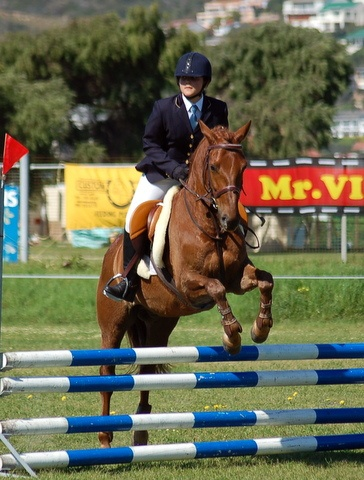

['person', 'horse', 'end']


'\n# image, multi_label(image에 대한 정보) 제대로 뽑혔는지 확인\nfor i in range(len(multi_labels)):\n  display(image_label.rare_images[i])\n  print(multi_labels[i])\n'

In [ ]:
#위의 셀에서의 beam search answer와 비교해볼 것
from PIL import Image
from IPython.display import display  # Jupyter Notebook에서 이미지를 출력하기 위해 사용
import tensorflow as tf


# 이미지 출력
def check_answer(index):
  display(image_label.rare_images[index])
  print(multi_labels[index])
check_answer(100)
#print(type(image_label.rare_images[1499]))
#image = tf.constant(image_label.rare_images[1499])
#print(image.shape)
#print(image)
